In [6]:
import numpy as np
import pandas as pd

import os
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import os

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
df = pd.read_csv("C:\\Users\\DOM\\Desktop\\tomography\\computed-tomography-ct-of-the-abdomen\\ct_abdomen.csv")

In [8]:
EPOCHS = 10 # Количество эпох для обучения модели
LR = 0.1 # Начальная скорость обучения
BATCH = 32 # Размер батча для обучения
IM_SIZE = 224 # Размер входных изображений
STEP = 5 # Шаг для уменьшения скорости обучения
GAMMA = 0.1 # Фактор уменьшения скорости обучения
NUM_CLASSES = df["type"].nunique() # Количество уникальных классов в данных

In [9]:
df.drop(["dcm"], axis=1, inplace=True) # 

In [10]:
le = LabelEncoder() # Инициализация энкодера для преобразования текстовых меток в числа
df["type"] = le.fit_transform(df.iloc[:, -1].values) # Преобразование последнего столбца в числовые метки и сохранение обратно в столбец 'type'

In [11]:
base_dir = 'C:\\Users\\DOM\Desktop\\tomography\\computed-tomography-ct-of-the-abdomen\\files\\files'
df["jpg"] = df["jpg"].apply(lambda x: os.path.join(base_dir, x[1:]))

In [12]:
# Разделение исходных данных на обучающий набор и временный тестовый набор с 20% данных
train, tests = train_test_split(df, random_state=42, test_size=0.2)
# Дальнейшее разделение временного тестового набора на валидационный и окончательный тестовый наборы, поровну
val, test = train_test_split(tests, random_state=42, test_size=0.5)


In [13]:
X = []  # Инициализация списка для хранения изображений
Y = []  # Инициализация списка для хранения меток классов

# Цикл по всем строкам в обучающем наборе данных
for i in range(len(train)):
    img = Image.open(train.iloc[i, 0])  # Загрузка изображения по пути из первого столбца текущей строки
    hr = img.transpose(method=Image.FLIP_LEFT_RIGHT)  # Создание горизонтально отраженной копии изображения
    vr = img.transpose(method=Image.FLIP_TOP_BOTTOM)  # Создание вертикально отраженной копии изображения
    
    X.append(np.array(img))  # Добавление оригинального изображения в список изображений как массив NumPy
    Y.append(train.iloc[i, -1])  # Добавление метки класса из последнего столбца текущей строки в список меток
    
    X.append(np.array(hr))  # Добавление горизонтально отраженного изображения в список изображений
    Y.append(train.iloc[i, -1])  # Добавление соответствующей метки класса для горизонтально отраженного изображения
    
    X.append(np.array(vr))  # Добавление вертикально отраженного изображения в список изображений
    Y.append(train.iloc[i, -1])  # Добавление соответствующей метки класса для вертикально отраженного изображения


In [14]:
class Clod(torch.nn.Module):
    """
    загрзука данных, применение предварительных преобразований
    и извлечение элементов по индексу
    """
    
    def __init__(self, data, target=None, transform=None):
        super(Clod, self).__init__()
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)# Возвращает общее количество элементов в датасете.

    
    def __getitem__(self, idx):
        # Если метки предоставлены явно, используем их
        if self.target is not None:
            image, label = self.data[idx], self.target[idx]
        # Иначе предполагаем, что данные находятся в DataFrame
        else:
            image_path, label = self.data.iloc[idx, 0], self.data.iloc[idx, -1]
            image = Image.open(image_path).convert('RGB')  # Загрузка изображения и преобразование в RGB
            image = np.array(image)  # Преобразование изображения в массив NumPy

        # Применяем трансформации к изображению, если они есть
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Преобразует тензор или массив numpy в изображение PIL.
    transforms.ToTensor(),  # Преобразует изображение PIL или numpy.ndarray (H x W x C) в тензор PyTorch (C x H x W).
    transforms.Resize((IM_SIZE, IM_SIZE)),  # Изменяет размер изображения к указанному размеру.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Нормализует тензор изображения, используя среднее и стандартное отклонение.
                         std=[0.229, 0.224, 0.225])
])


In [16]:
train_ds = Clod(X, Y, transform) # тренировочный датасет
val_ds = Clod(val, None, transform) # валидационный датасет

In [17]:
# дата лоадары
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [18]:
# устройство для вычислений gpu/cpu 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [19]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
for param in model.parameters():
    param.requires_grad_ = False
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
model.fc.requires_grad_ = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\DOM/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


In [20]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=GAMMA, step_size=STEP)

In [23]:
best_model = deepcopy(model)
best_acc = 0.0

acc_train = []
acc_val = []
loss_train = []
loss_val = []

for i in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    
    for data, label in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()
        label = label.long()  # Приведение меток классов к типу Long

        out = model(data)
        loss = criterion(out, label)
        train_loss += loss.item()
        train_acc += (out.argmax(1) == label).sum().item()
        train_total += out.size(0)
        loss.backward()
        optimizer.step()

        
    train_loss /= train_total
    train_acc /= train_total
        
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0
    
    with torch.no_grad():
        for data, label in val_dl:
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()
            label = label.long()  # Приведение меток классов к типу Long

            out = model(data)
            loss = criterion(out, label)
            val_loss += loss.item()
            val_acc += (out.argmax(1) == label).sum().item()
            val_total += out.size(0)

            
    val_acc /= val_total
    val_loss /= val_total
    acc_train += [train_acc]
    acc_val += [val_acc]
    loss_train += [train_loss]
    loss_val += [val_loss]
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
        
    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss, train_acc, val_loss, val_acc))
    scheduler.step()

Epoch 1 train loss 0.008896445813729406 acc 0.9156305506216696 val loss 5.32185989068755e-05 acc 1.0
Epoch 2 train loss 6.919009384589988e-05 acc 1.0 val loss 1.9052794330310844e-05 acc 1.0
Epoch 3 train loss 3.3384046359541854e-05 acc 1.0 val loss 1.2261270180489894e-05 acc 1.0
Epoch 4 train loss 2.070040468379079e-05 acc 1.0 val loss 8.156357877161222e-06 acc 1.0
Epoch 5 train loss 1.512799461759145e-05 acc 1.0 val loss 6.148484407541018e-06 acc 1.0
Epoch 6 train loss 1.434772076796384e-05 acc 1.0 val loss 5.983502533062236e-06 acc 1.0
Epoch 7 train loss 1.4823917564355629e-05 acc 1.0 val loss 6.321969347946504e-06 acc 1.0
Epoch 8 train loss 1.4945776637911283e-05 acc 1.0 val loss 5.756189542201658e-06 acc 1.0
Epoch 9 train loss 1.6459990513521755e-05 acc 1.0 val loss 5.3527118396245156e-06 acc 1.0
Epoch 10 train loss 1.4412011917779203e-05 acc 1.0 val loss 5.495862796711108e-06 acc 1.0


In [24]:
torch.save(best_model, 'full_model.pth')

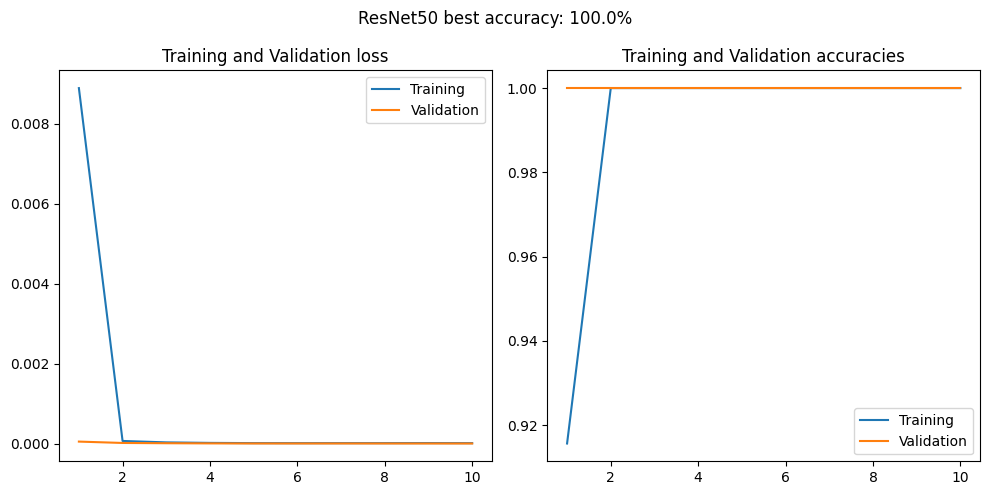

In [25]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(epochs, loss_train)
axes[0].plot(epochs, loss_val)
axes[0].set_title("Training and Validation loss")
axes[0].legend(["Training", "Validation"])
axes[1].plot(epochs, acc_train)
axes[1].plot(epochs, acc_val)
axes[1].set_title("Training and Validation accuracies")
axes[1].legend(["Training", "Validation"])
plt.suptitle("ResNet50 best accuracy: {}%".format(round(best_acc*100, 2)))
plt.tight_layout()
plt.show()

In [26]:
def predict(value):
    image = Image.open(value).convert("RGB")
    image = np.array(image)
    image = transform(image)
    image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])
    if torch.cuda.is_available():
        image = image.cuda()
    best_model.eval()
    with torch.no_grad():
        out = model(image)
    index = out.argmax(1).item()
    return index

In [27]:
predicted = []
gt = []
for i in range(len(test)):
    predicted += [predict(test.iloc[i, 0])]
    gt += [test.iloc[i, -1]]

Test image score: 100.0%
Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00         8

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



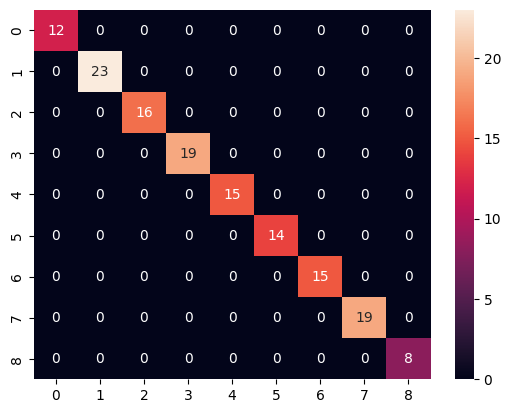

In [28]:
score = accuracy_score(predicted, gt)
report = classification_report(predicted, gt)
cm = confusion_matrix(predicted, gt)
print("Test image score: {}%".format(round(score*100, 2)))
print("Report")
print(report)
sns.heatmap(cm, annot=True)
plt.show()

In [29]:
predicted = le.inverse_transform(predicted)
gt = le.inverse_transform(gt)

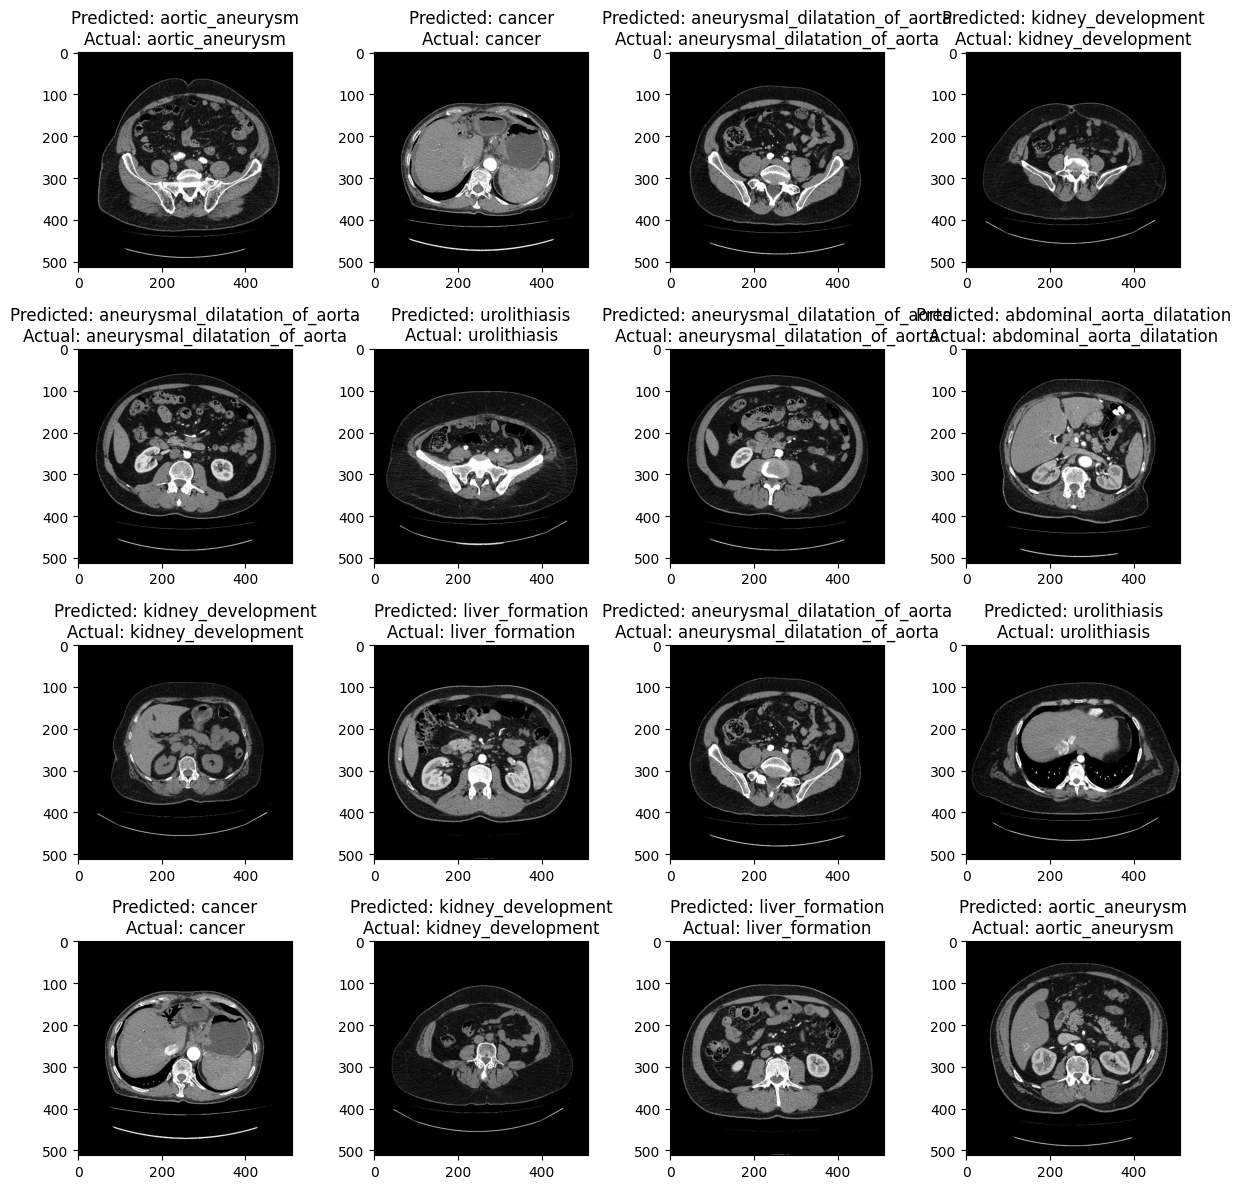

In [30]:
index = 0
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        im = plt.imread(test.iloc[index, 0])
        axes[i][j].imshow(im)
        axes[i][j].set_title("Predicted: {}\nActual: {}".format(predicted[index], gt[index]))
        index += 1
        
plt.tight_layout()
plt.show()